This uses LinearSVC instead of gaussian because I could gaussian and randomforest require two different output arrays but LinearSVC required only sparse matrices. Also has the visualization I did wednesday, 


In [2]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 5.8 MB/s eta 0:00:00m eta 0:00:010:01:01
  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl (29 kB)
  Using cached spacy_loggers-1.0.4-py3-none-any.whl (11 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 770.0/770.0 kB 7.7 MB/s eta 0:00:00m eta 0:00:010:01
  Using cached wasabi-1.1.1-py3-none-any.whl (27 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.6/487.6 kB 2.6 MB/s eta 0:00:003.0 MB/s eta 0:00:01
  Using cached catalogue-2.0.8-py3-none-any.whl (17 kB)
  Using cached typer-0.7.0-py3-none-any.whl (38 kB)
  Using cached pathy-0.10.1-py3-none-any.whl (48 kB)
  Using cached smart_open-6.3.0-py3-none-any.whl (56 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 4.1 MB/s eta 0:00:00m eta 0:00:010:01:01
  Using cached langcodes-3.3.0-py3-none-any.whl (181 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 3.2 MB/s eta 0:0

In [41]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from collections import defaultdict 
import spacy
import en_core_web_sm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression # just to see if the model is even working
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
import pickle
from sklearn.metrics import accuracy_score
import re
from collections import Counter 

In [4]:
import os
# print(os.getcwd())

In [6]:
raw = pd.read_csv('ted_talks_en.csv')

In [7]:
raw.head()

,talk_id,title,speaker_1,all_speakers,occupations,about_speakers,views,recorded_date,published_date,event,native_lang,available_lang,comments,duration,topics,related_talks,url,description,transcript
0,1,Averting the climate crisis,Al Gore,{0: 'Al Gore'},{0: ['climate advocate']},{0: 'Nobel Laureate Al Gore focused the world’...,3523392,2006-02-25,2006-06-27,TED2006,en,"['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...",272.0,977,"['alternative energy', 'cars', 'climate change...","{243: 'New thinking on the climate crisis', 54...",https://www.ted.com/talks/al_gore_averting_the...,With the same humor and humanity he exuded in ...,"Thank you so much, Chris. And it's truly a gre..."
1,92,The best stats you've ever seen,Hans Rosling,{0: 'Hans Rosling'},{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...",14501685,2006-02-22,2006-06-27,TED2006,en,"['ar', 'az', 'bg', 'bn', 'bs', 'cs', 'da', 'de...",628.0,1190,"['Africa', 'Asia', 'Google', 'demo', 'economic...","{2056: ""Own your body's data"", 2296: 'A visual...",https://www.ted.com/talks/hans_rosling_the_bes...,You've never seen data presented like this. Wi...,"About 10 years ago, I took on the task to teac..."
2,7,Simplicity sells,David Pogue,{0: 'David Pogue'},{0: ['technology columnist']},{0: 'David Pogue is the personal technology co...,1920832,2006-02-24,2006-06-27,TED2006,en,"['ar', 'bg', 'de', 'el', 'en', 'es', 'fa', 'fr...",124.0,1286,"['computers', 'entertainment', 'interface desi...","{1725: '10 top time-saving tech tips', 2274: '...",https://www.ted.com/talks/david_pogue_simplici...,New York Times columnist David Pogue takes aim...,"(Music: ""The Sound of Silence,"" Simon & Garfun..."
3,53,Greening the ghetto,Majora Carter,{0: 'Majora Carter'},{0: ['activist for environmental justice']},{0: 'Majora Carter redefined the field of envi...,2664069,2006-02-26,2006-06-27,TED2006,en,"['ar', 'bg', 'bn', 'ca', 'cs', 'de', 'en', 'es...",219.0,1116,"['MacArthur grant', 'activism', 'business', 'c...",{1041: '3 stories of local eco-entrepreneurshi...,https://www.ted.com/talks/majora_carter_greeni...,"In an emotionally charged talk, MacArthur-winn...",If you're here today — and I'm very happy that...
4,66,Do schools kill creativity?,Sir Ken Robinson,{0: 'Sir Ken Robinson'},"{0: ['author', 'educator']}","{0: ""Creativity expert Sir Ken Robinson challe...",65051954,2006-02-25,2006-06-27,TED2006,en,"['af', 'ar', 'az', 'be', 'bg', 'bn', 'ca', 'cs...",4931.0,1164,"['children', 'creativity', 'culture', 'dance',...","{865: 'Bring on the learning revolution!', 173...",https://www.ted.com/talks/sir_ken_robinson_do_...,Sir Ken Robinson makes an entertaining and pro...,Good morning. How are you? (Audience) Good. It...


In [8]:
arr = raw['topics'].to_numpy()
keywords = defaultdict(int)
for i, inner in enumerate(arr):
    x = inner.split("'")
    for i, tag in enumerate(x):
        if i % 2 != 0 and i != 0 and i != len(x) - 1:
            keywords[tag.lower()] += 1

In [9]:
most_common_keywords = sorted(list(keywords.keys()), key=lambda keyword: keywords[keyword])[::-1]
occurences = [keywords[keyword] for keyword in most_common_keywords]
#list(zip(most_common_keywords, occurences))

(array([176., 103.,  45.,  31.,  25.,  10.,  10.,  10.,   7.,   3.,   5.,
          6.,   2.,   2.,   1.,   1.,   3.,   2.,   1.,   2.,   1.,   0.,
          2.,   0.,   1.,   2.,   0.,   1.,   2.,   1.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.]),
 array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180., 200.,
        220., 240., 260., 280., 300., 320., 340., 360., 380., 400., 420.,
        440., 460., 480., 500., 520., 540., 560., 580., 600., 620., 640.,
        660., 680., 700., 720., 740., 760., 780., 800., 820., 840., 860.,
        880., 900., 920., 940., 960., 980.]),
 <BarContainer object of 49 artists>)

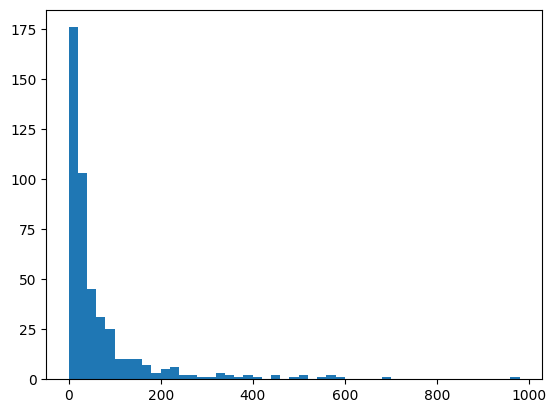

In [10]:
plt.hist(occurences, bins=np.arange(0, 1000, 20))

In [11]:
cutoff = 50
y = filter(lambda x: x >= cutoff, occurences)
print(f"Amount of topics with occurences >= {cutoff} : {len(list(y))}")

Amount of topics with occurences >= 50 : 156


In [12]:
def convert_topics(topic):
    x = topic.split("'")
    tags = []
    for i, tag in enumerate(x):
        if i % 2 != 0 and i != 0 and i != len(x) - 1:
            tags.append(tag.lower())
    return tags

def correct_dataframe_topics_column(df, in_place=False):
    if not in_place:
        df = df.copy()
    topics_listed_column = df['topics'].apply(convert_topics)
    df['topics'] = topics_listed_column
    return df

In [13]:
"""
Topics of focus:
STEM - Science, Technology, Engineering, Math(Mathematics), Psychology, Physics, Biotech, AI, Cognitive Science
Culture - Culture, Society, Community
Business - Business, Economics
Social Change - social change/activism
History - History/Politics
"""
topic_to_group = defaultdict(lambda: 'not-relevant')

# science = ["science", "psychology", "biotech","cognitive science", 'health']
# technology = ["technology", 'computers', 'software', 'visualizations']
# engineering = ["engineering", "ai",]
# math = ["math", "mathematics", "physics"]

stem = ["science", "technology", "engineering", "math", "mathematics", "psychology", "physics", "biotech", "ai", "cognitive science", 'math', 'computers', 'science', 'software', 'technology', 'visualizations', 'health']
culture = ["culture", "society", "community", 'culture', 'humor', 'visualizations', 'children', 'creativity', 'entertainment', 'media', 'education', 'parenting', 'teaching', 'collaboration', 'music', 'performance', 'activism', 'africa', 'inequality', 'politics']
business = ["business", "economics",  'design', 'comedy', 'storytelling', 'entertainment', 'media', 'business', 'cities', 'demo', 'economics']
activism = ['social change', 'activism',  'climate change', 'environment', 'global issues', 'sustainability', 'green', 'inequality', 'global development', 'pollution']
history = ['history', 'politics',  'creativity', 'architecture', 'religion', 'storytelling']
categories = [ ['stem'] + stem, ['culture'] + culture, ['business'] + business,
              ['activism'] + activism, ['history'] + history]

# categories = [ ['math'] + math, ['science'] + science, 
#               ['technology'] + technology, 
#               ['engineering'] + engineering, 
#               ['science'] + science,
#               ['culture'] + culture, ['business'] + business,
#               ['activism'] + activism, ['history'] + history]


for category in categories:
    cat = None
    for i, topic in enumerate(category):
        if i == 0:
            cat = topic
            continue
        topic_to_group[topic] = cat

In [14]:
def group_topics(topic_list):
    grouped = defaultdict(int)
    for topic in topic_list:
        grouped[topic_to_group[topic]] += 1
    vals_with_keys = sorted(
        [(topic, grouped[topic]) for topic in grouped.keys()],
        key=lambda tup: tup[1])[::-1]
    for tup in vals_with_keys: 
        if tup[0] != 'not-relevant': 
            return tup[0]
    return "not-relevant"

def group_df_topics(df, in_place=False):
    if not in_place:
        df = df.copy()
    df['grouped_topics'] = df['topics'].apply(group_topics)
    return df

In [15]:
def count_unique_words(script): 
    unique_words = dict()
    script_lst = script.split()
    for word in script_lst: 
        if word in unique_words: 
            unique_words[word] += 1
        else: 
            unique_words[word] = 1
    return unique_words

def add_words(df, in_place=False):
    if in_place:
        df = df.copy()
    df["clean_scripts"] = (
    df["transcript"]
    .str.replace(r'\(Music: [^)]+\) ','', regex = True)
    .str.replace(r' — ', ' ', regex = True)
    .str.replace(r'[[."\'!\],:?;=+*&]', '', regex = True)
    .str.lower())
    df["words"] = df["clean_scripts"].apply(count_unique_words)
    return df

In [16]:
# NOT USING RIGHT NOW 
def one_hot_encode(df: pd.DataFrame, verbose=False, in_place=False):
    """
    expects df to have a columns ['words'] which contains a dictionary for each entry,
    this dictionary has all the unique words in this row's transcript as keys, and their values
    correspond the amount of time that word appears in the transcript. This creates 
    """
    word_dicts = df['words'].to_numpy()
    total_dict = defaultdict(int)
    total_count = 0
    for word_dict in word_dicts:
        for word in word_dict.keys():
            total_dict[word] += word_dict[word]
            total_count += word_dict[word]
    unique_count = len(list(total_dict.keys()))
    if verbose: 
        print("Amount of unique words: {:,}".format(unique_count), 
             "\nTotal word count: {:,}".format(total_count))
    
    word_to_onehot_location = {}
    for i, word in enumerate(list(total_dict.keys())):
        word_to_onehot_location[word] = i
        
    new_col = []
    for i, row in enumerate(word_dicts):
        new_entry = np.zeros(unique_count, dtype=int)
        for word in row:
            new_entry[word_to_onehot_location[word]] = 1
        new_col.append(new_entry)
    if in_place:
        new_df = df
    else:
        new_df = df.copy()
    new_df['one-hot'] = new_col
    return new_df

def sentence_type(df, in_place=False):
    """
    adds an array to each row
    this array contains the frequency of each setence type
    arr[0] = . | arr[1] = ? | arr[2] = !
    each entry is total occurences / total punctuation count
    """
    new_col = []
    for transcript in df['transcript']:
        new_entry = np.zeros(3)
        p_count, q_count, e_count = transcript.count('.'), transcript.count('?'), transcript.count('!')
        total_sentences = p_count + q_count + e_count + 1
        new_entry[0] = (p_count + 1)/ total_sentences
        new_entry[1] = (q_count + 1)/ total_sentences
        new_entry[2] = (e_count + 1)/ total_sentences
        new_col.append(new_entry)
    if in_place:
        new_df = df
    else:
        new_df = df.copy()
    new_df['sentence-type'] = new_col
    return new_df


In [17]:
## TFIDF Calculation


# NOT USING RIGHT NOW 
def tfidf_value(transcript):
    tfIdfVectorizer = TfidfVectorizer(use_idf=True)
    tfIdf = tfIdfVectorizer.fit_transform([transcript])
    #list_of_words_tfidf = tfIdfVectorizer.get_feature_names_out()
    tfidf_value = tfIdf.toarray()[0]
    return tfidf_value

def tfidf_words(transcript):
    tfIdfVectorizer = TfidfVectorizer(use_idf=True)
    tfIdf = tfIdfVectorizer.fit_transform([transcript])
    try:
        list_of_words_tfidf = tfIdfVectorizer.get_feature_names_out()
    except Error:
        list_of_words_tfidf = tfIdfVectorizer.get_feature_names()
    tfidf_words = list_of_words_tfidf
    return tfidf_words

def tfidf_dict(transcript):
    tfIdfVectorizer = TfidfVectorizer(use_idf=True)
    tfIdf = tfIdfVectorizer.fit_transform([transcript])
    try:
        list_of_words_tfidf = tfIdfVectorizer.get_feature_names_out()
    except Error:
        list_of_words_tfidf = tfIdfVectorizer.get_feature_names()
    tfidf_value = tfIdf.toarray()[0]
    tfidf_dict = dict(zip(list_of_words_tfidf,tfidf_value))
    return tfidf_dict

def add_tfidf(df: pd.DataFrame, in_place=False):
    if in_place:
        df = df.copy()
    df['tfidf'] = df['transcript'].apply(tfidf_value)
    df['tfidf_word'] = df['transcript'].apply(tfidf_words)
    df['tfidf_dict'] = df['transcript'].apply(tfidf_dict)
    return df

In [18]:
# NOT USING RIGHT NOW 
def get_feature_engineered():
    data = raw.copy()
    data = correct_dataframe_topics_column(data, in_place=True)
    data = group_df_topics(data, in_place=True)
    data = add_words(data, in_place=True)
    data = one_hot_encode(data, in_place=True)
    data = sentence_type(data, in_place=True)
    data = add_tfidf(data, in_place=True)
    data = data.drop(columns = [
    "talk_id", "speaker_1", "recorded_date", 
    "event", "duration", "url", "comments", "about_speakers", 
    "available_lang", "all_speakers", "native_lang"])
    return data

In [19]:
def get_cleaned_data():
    data = raw.copy()
    data = correct_dataframe_topics_column(data, in_place=True)
    data = group_df_topics(data, in_place=True)
    data = add_words(data, in_place=True)
    data = sentence_type(data, in_place=True)
    data = data.drop(columns = [
    "talk_id", "speaker_1", "recorded_date", "published_date", 
    "event", "url", "about_speakers", 
    "available_lang", "all_speakers", "native_lang", "occupations", "related_talks", "description", "sentence-type"])
    return data

In [20]:
data_eda = get_cleaned_data()

/Users/sebastian/miniforge3/envs/ted-talks/lib/python3.11/site-packages/pandas/core/strings/object_array.py:158: FutureWarning: Possible nested set at position 1
  pat = re.compile(pat, flags=flags)


In [21]:
data_eda["grouped_topics"].value_counts()

stem            1445
culture          946
activism         662
business         445
history          356
not-relevant     151
Name: grouped_topics, dtype: int64

In [22]:
data_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4005 entries, 0 to 4004
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           4005 non-null   object 
 1   views           4005 non-null   int64  
 2   comments        3350 non-null   float64
 3   duration        4005 non-null   int64  
 4   topics          4005 non-null   object 
 5   transcript      4005 non-null   object 
 6   grouped_topics  4005 non-null   object 
 7   clean_scripts   4005 non-null   object 
 8   words           4005 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 281.7+ KB


tfidf --> clean_script 
ohe --> all of the words 
ohe --> grouped topics 
standardize --> duration 
standardize --> views
standardize --> comments

In [23]:
df_count = pd.Series(keywords).to_frame().reset_index().rename(columns = {"index": "category", 0:"count"})

df_count = df_count[df_count["count"] >= 50]
total_count = df_count.shape[0]

lst = []
for i in range(0, total_count, 39):
    df_cut = df_count.iloc[i: i+ 39]
    lst.append(df_cut)

In [24]:
# np.array(data_eda["clean_scripts"])

In [25]:
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
# from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV


In [26]:
# X = data_eda.fillna(0)
# y = data_eda["grouped_topics"]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20) 

# preproc = ColumnTransformer(
#     transformers = [
#         ("tfidf", TfidfVectorizer(stop_words = "english"), "clean_scripts"), # only need to be taken in a series
# #         ('std_views', StandardScaler(), ["views"]), 
# #         ('std_comments', StandardScaler(), ["comments"])
#     ],
#     remainder = "drop"
# )

# lvc_pipeline = Pipeline([
#     ('preprocessor', preproc),
#     ('classifier', LinearSVC(C=3))
# ])

# pl_decision_tree = Pipeline([ 
#     ('naive_bayes', nb_pipeline),
#     ("dec_tree", DecisionTreeClassifier(max_depth = 3))
# ])

# pl_kmeans = Pipeline([
#     ('preprocessor', preproc),
#     ('classifier', KMeans(n_init=10))
    
# ])

# lvc_pipeline.fit(X_train, y_train)
# predict = lvc_pipeline.predict(X_train)

# # pl_kmeans.fit(X_train, y_train)
# # predict = pl_kmeans.predict(X_train)


In [27]:
X = data_eda
y = data_eda["grouped_topics"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25) 

preproc = ColumnTransformer(
    transformers = [
        ("tfidf", TfidfVectorizer(stop_words = "english"), "clean_scripts"), # only need to be taken in a series
#         ('std_views', StandardScaler(), ["views"]), 
#         ('std_comments', StandardScaler(), ["comments"])
    ],
    remainder = "drop"
)

lvc_pipeline = Pipeline([
    ('preprocessor', preproc),
    ('classifier', LinearSVC(C=1, tol = 1e-5, loss="hinge"))
#     ('classifier', LinearSVC(C=1, penalty = 'l1', dual = False, multi_class = 'crammer_singer'))

])

lvc_pipeline.fit(X_train, y_train)
predict = lvc_pipeline.predict(X_train)


# hyperparameters = {
#     'classifier__C' : np.arange(1, 7, 1),
#     'classifier__max_iter' : np.arange(1000, 10000, 1000), 

# }

# pl_final = Pipeline([
#     ('grid_search', GridSearchCV(lvc_pipeline, param_grid = hyperparameters)
#     )
# ])

# pl_final.fit(X_train, y_train)


# pl_final.named_steps['grid_search'].best_params_


In [28]:
# bar chart by topic - see what is right and what isn't right and create a visualization based on that 

In [29]:
accuracy_score(y_train, predict)

0.9647019647019647

In [42]:
predict_test = lvc_pipeline.predict(X_test)
accuracy_score(y_test, predict_test)


def test_str(s, pipeline):
    str_arr = pd.Series(s).to_frame()
    str_arr = str_arr.rename(columns = {0:"clean_scripts"})
    return pipeline.predict(str_arr)

file_name = "model_scv.sav"
pickle.dump(lvc_pipeline, open(file_name, 'wb'))

In [31]:
string = "Cyrus, king of the Persians, has entered Babylon without a fight -- the great empire of Babylon, which ran from central southern Iraq to the Mediterranean, falls to Cyrus. And Cyrus makes a declaration. And that is what this cylinder is, the declaration made by the ruler guided by God who had toppled the Iraqi despot and was going to bring freedom to the people. In ringing Babylonian -- it was written in Babylonian -- he says, \"I am Cyrus, king of all the universe, the great king, the powerful king, king of Babylon, king of the four quarters of the world.\" They\'re not shy of hyperbole as you can see. This is probably the first real press release by a victorious army that we\'ve got. And it\'s written, as we\'ll see in due course, by very skilled P.R. consultants. So the hyperbole is not actually surprising."
str_arr = pd.Series(string).to_frame()
str_arr = str_arr.rename(columns = {0:"clean_scripts"})
lvc_pipeline.predict(str_arr)

array(['history'], dtype=object)

In [32]:
pd.DataFrame(predict_test).value_counts()/len(predict_test)

stem            0.480040
culture         0.239521
activism        0.168663
business        0.060878
history         0.049900
not-relevant    0.000998
dtype: float64

In [33]:
pd.DataFrame(y_test).value_counts()/len(y_test)

grouped_topics
stem              0.394212
culture           0.217565
activism          0.164671
business          0.111776
history           0.078842
not-relevant      0.032934
dtype: float64

In [34]:
data_eda["grouped_topics"].value_counts()/data_eda.shape[0]

stem            0.360799
culture         0.236205
activism        0.165293
business        0.111111
history         0.088889
not-relevant    0.037703
Name: grouped_topics, dtype: float64

In [35]:
# data_eda.plot.scatter(x='views', y='duration', c='grouped_topics')

In [36]:
3376/len(data_eda['grouped_topics'])

0.8429463171036204

In [37]:
## start of first viz

In [38]:
# featured_data = get_feature_engineered()
featured_data = data_eda.copy()

In [39]:
grouped_df = featured_data.groupby('grouped_topics')['views'].median().sort_values()
grouped_df

grouped_topics
history         1211816.0
activism        1284481.0
business        1320195.0
not-relevant    1412008.0
culture         1428382.0
stem            1446216.0
Name: views, dtype: float64

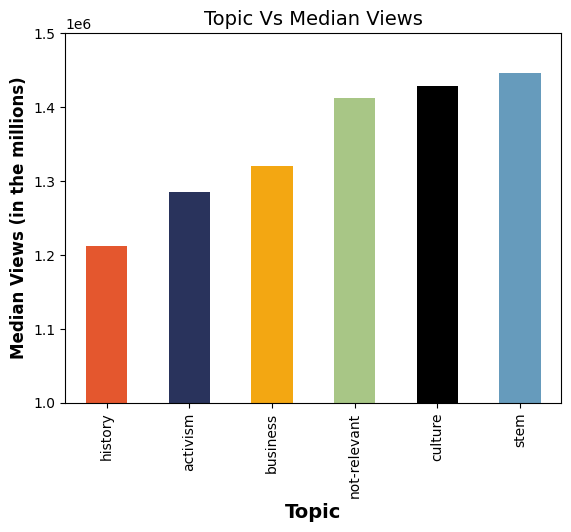

In [40]:
plot = grouped_df.plot.bar(x = 'grouped_topics', y = 'views',color = ['#e4572e','#29335c','#F3A712','#A8C686','black','#669BBC'])
plot.set_xlabel('Topic', fontsize = 14,fontweight = 'bold')
plot.set_ylabel('Median Views (in the millions)',fontsize = 12,fontweight = 'bold')
plot.set_ylim(1000000,1500000)
plot.set_title('Topic Vs Median Views',fontsize = 14)
plt.show()

In [ ]:
## start of second viz 

## maybe do publish date vs the topic most talked about

## might be bit hard to do. 

In [ ]:
featured_data['words'][0].values()

In [ ]:
date_group_df = featured_data.groupby('published_date')['views'].median()
date_group_df